# Library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV



# Data processing

In [2]:
# Loading the training and testing datasets
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

## Hander missing value

In [3]:
# Identifying numerical and categorical columns with missing values

# For training data
missing_train_cols = train_df.columns[train_df.isnull().any()]
num_cols_train = train_df[missing_train_cols].select_dtypes(include=["float64", "int64"]).columns
cat_cols_train = train_df[missing_train_cols].select_dtypes(include=["object"]).columns

# For testing data
missing_test_cols = test_df.columns[test_df.isnull().any()]
num_cols_test = test_df[missing_test_cols].select_dtypes(include=["float64", "int64"]).columns
cat_cols_test = test_df[missing_test_cols].select_dtypes(include=["object"]).columns

num_cols_train, cat_cols_train, num_cols_test, cat_cols_test


(Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object'),
 Index(['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
        'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu',
        'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
        'Fence', 'MiscFeature'],
       dtype='object'),
 Index(['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
        'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt',
        'GarageCars', 'GarageArea'],
       dtype='object'),
 Index(['MSZoning', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd',
        'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
        'BsmtFinType2', 'KitchenQual', 'Functional', 'FireplaceQu',
        'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
        'Fence', 'MiscFeature', 'SaleType'],
       dtype='object'))

In [4]:
# Checking for missing values in training and testing datasets
missing_train = train_df.isnull().sum().sort_values(ascending=False)
missing_test = test_df.isnull().sum().sort_values(ascending=False)

# Getting the top 10 columns with the most missing values for both datasets
missing_train_top10 = missing_train[missing_train > 0].head(10)
missing_test_top10 = missing_test[missing_test > 0].head(10)

missing_train_top10, missing_test_top10


(PoolQC          1453
 MiscFeature     1406
 Alley           1369
 Fence           1179
 FireplaceQu      690
 LotFrontage      259
 GarageYrBlt       81
 GarageCond        81
 GarageType        81
 GarageFinish      81
 dtype: int64,
 PoolQC          1456
 MiscFeature     1408
 Alley           1352
 Fence           1169
 FireplaceQu      730
 LotFrontage      227
 GarageYrBlt       78
 GarageQual        78
 GarageFinish      78
 GarageCond        78
 dtype: int64)

In [5]:
# Imputing missing values

# Numerical columns: impute with median
for col in num_cols_train:
    median_value = train_df[col].median()
    train_df[col].fillna(median_value, inplace=True)
    if col in num_cols_test:  # Ensure the column exists in the test data
        test_df[col].fillna(median_value, inplace=True)

for col in num_cols_test:  # There might be additional numerical columns in test data with missing values
    median_value = test_df[col].median()
    test_df[col].fillna(median_value, inplace=True)

# Categorical columns: impute with "Unknown"
for col in cat_cols_train:
    train_df[col].fillna("Unknown", inplace=True)

for col in cat_cols_test:
    test_df[col].fillna("Unknown", inplace=True)

# Checking if all missing values have been imputed
missing_train_after = train_df.isnull().sum().max()
missing_test_after = test_df.isnull().sum().max()

missing_train_after, missing_test_after


(0, 0)

# Exploratory Data Analysis (EDA)

## Plotting the distribution of SalePrice

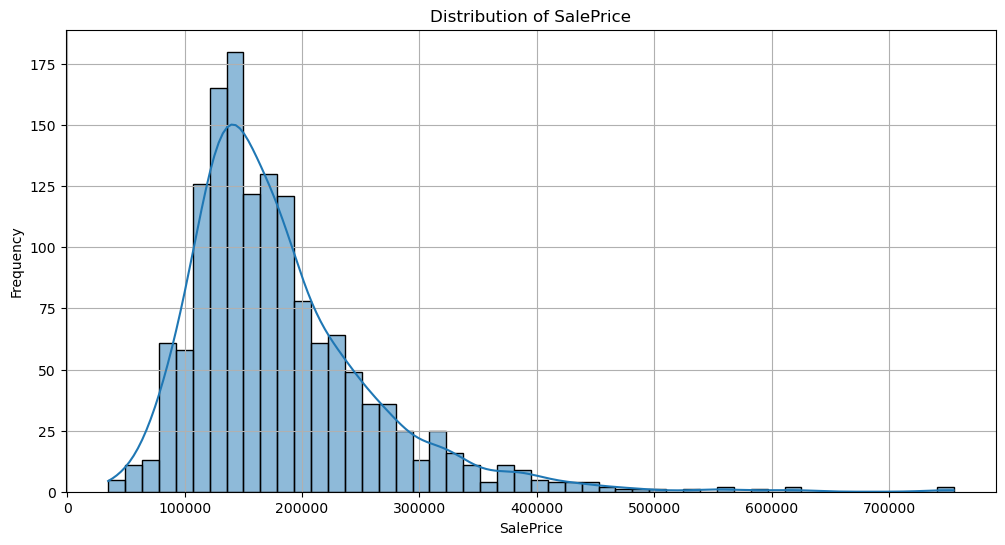

In [6]:
# Plotting the distribution of SalePrice
plt.figure(figsize=(12, 6))
sns.histplot(train_df["SalePrice"], bins=50, kde=True)
plt.title("Distribution of SalePrice")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

=> The distribution of SalePrice is right-skewed, which means most of the houses are clustered around the lower to mid-range prices, with a few houses being more expensive.


## Correlations between features and SalePrice

In [7]:
# Computing the correlation coefficients between SalePrice and other numerical features
correlations = train_df.corr()["SalePrice"].sort_values(ascending=False)

# Getting the top 10 positively correlated and top 10 negatively correlated features with SalePrice
top_positive_corr = correlations.head(11)[1:]  # Exclude SalePrice itself
top_negative_corr = correlations.tail(10)

top_positive_corr, top_negative_corr

/var/folders/y6/182wld891cn8s93gftsfv4nr0000gn/T/ipykernel_69980/1068348694.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = train_df.corr()["SalePrice"].sort_values(ascending=False)


(OverallQual     0.790982
 GrLivArea       0.708624
 GarageCars      0.640409
 GarageArea      0.623431
 TotalBsmtSF     0.613581
 1stFlrSF        0.605852
 FullBath        0.560664
 TotRmsAbvGrd    0.533723
 YearBuilt       0.522897
 YearRemodAdd    0.507101
 Name: SalePrice, dtype: float64,
 BsmtFinSF2      -0.011378
 BsmtHalfBath    -0.016844
 MiscVal         -0.021190
 Id              -0.021917
 LowQualFinSF    -0.025606
 YrSold          -0.028923
 OverallCond     -0.077856
 MSSubClass      -0.084284
 EnclosedPorch   -0.128578
 KitchenAbvGr    -0.135907
 Name: SalePrice, dtype: float64)

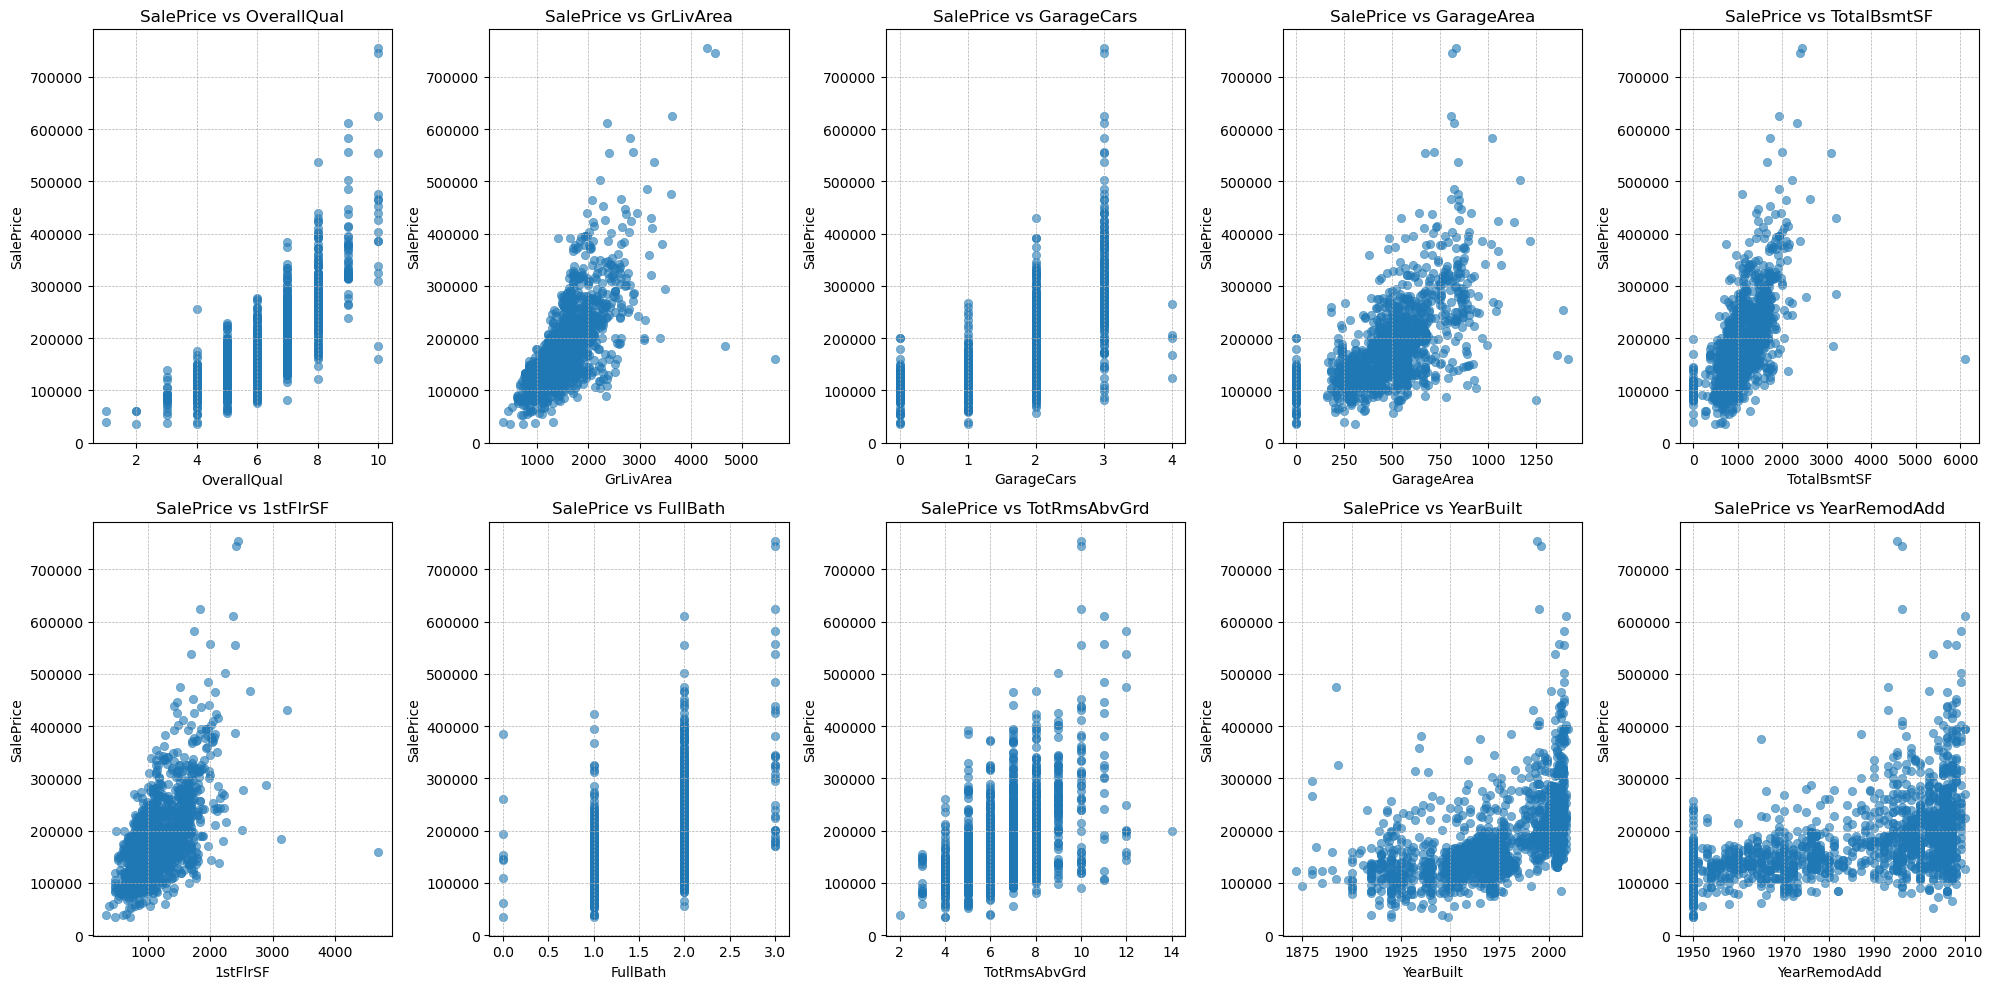

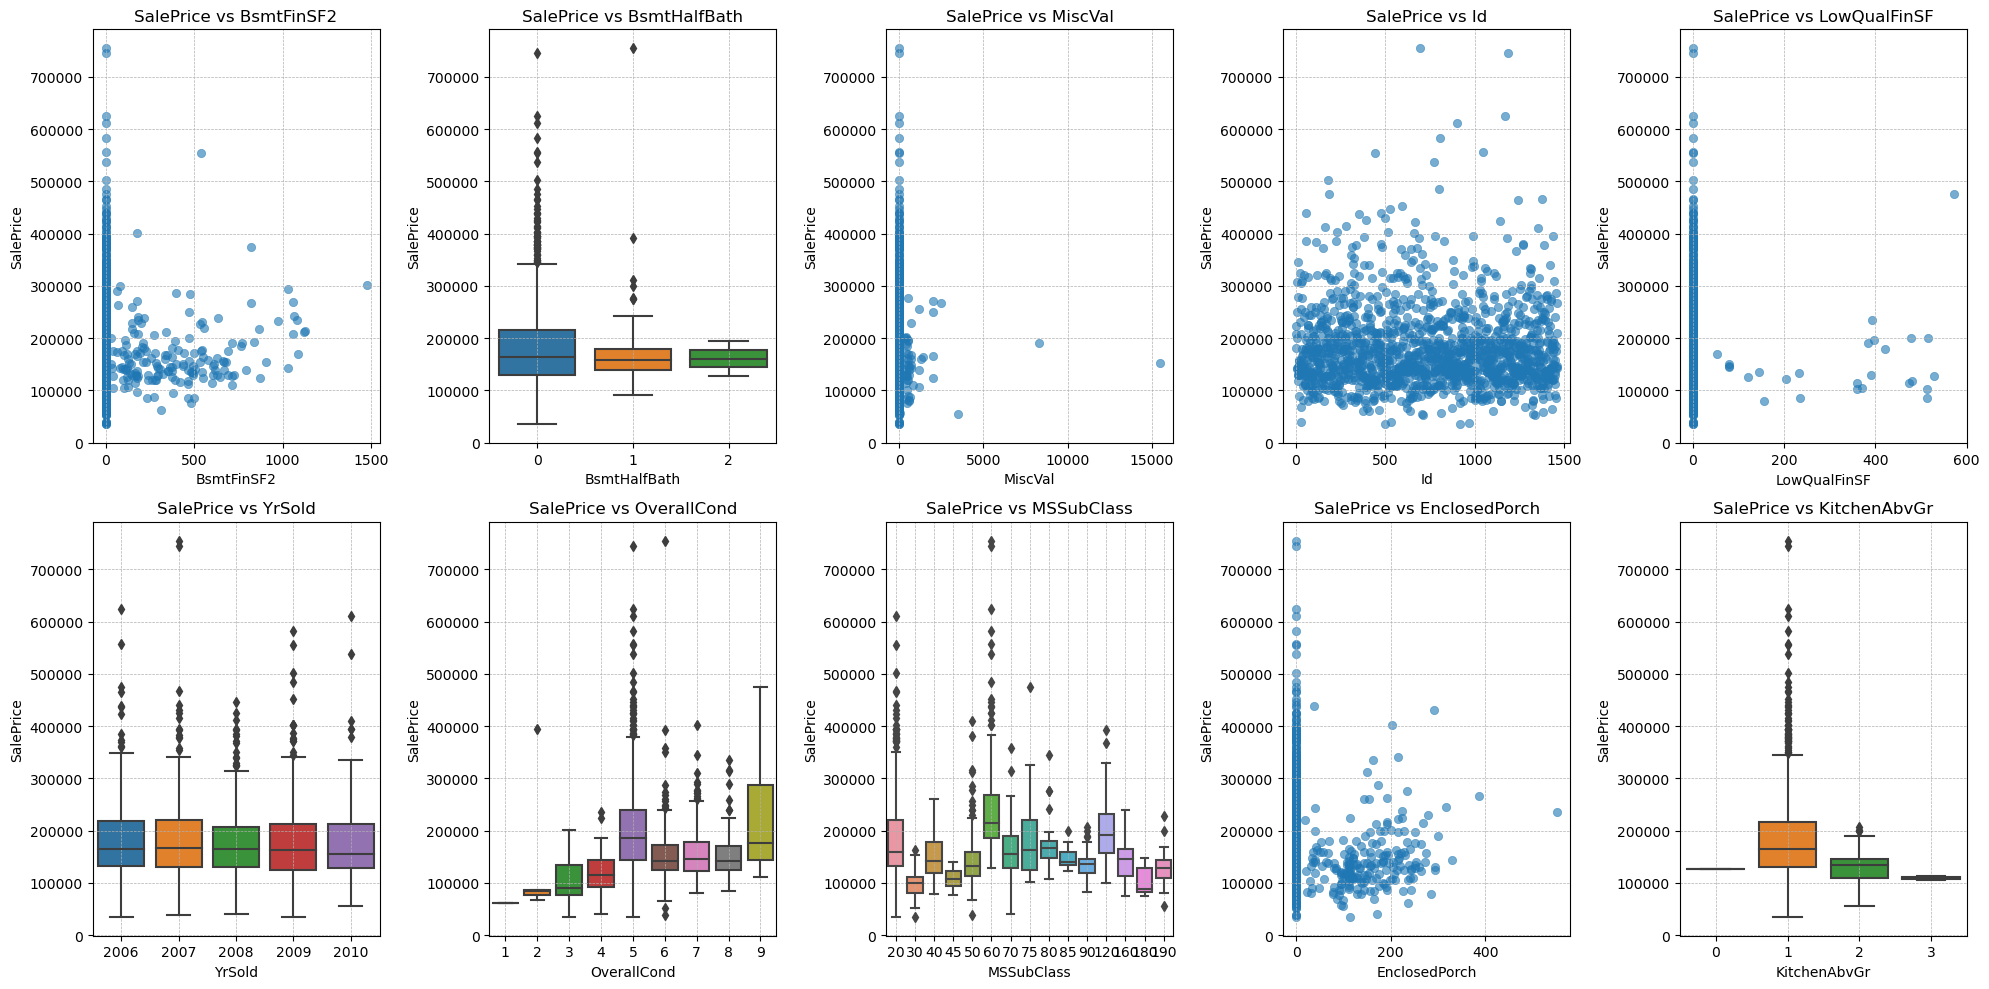

In [8]:
# Visualizing relationships between SalePrice and the top positively correlated features
plt.figure(figsize=(20, 10))
for i, col in enumerate(top_positive_corr.index, start=1):
    plt.subplot(2, 5, i)
    sns.scatterplot(data=train_df, x=col, y="SalePrice", alpha=0.6, edgecolor=None)
    plt.title(f"SalePrice vs {col}")
    plt.xlabel(col)
    plt.ylabel("SalePrice")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

# Visualizing relationships between SalePrice and the top negatively correlated features
plt.figure(figsize=(20, 10))
for i, col in enumerate(top_negative_corr.index, start=1):
    plt.subplot(2, 5, i)
    if train_df[col].nunique() < 20:  # If fewer unique values, use a boxplot
        sns.boxplot(data=train_df, x=col, y="SalePrice")
    else:
        sns.scatterplot(data=train_df, x=col, y="SalePrice", alpha=0.6, edgecolor=None)
    plt.title(f"SalePrice vs {col}")
    plt.xlabel(col)
    plt.ylabel("SalePrice")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


# Feature Engineering

In [9]:
# Implementing feature engineering steps

# 1. Total Square Footage
train_df["TotalSF"] = train_df["GrLivArea"] + train_df["TotalBsmtSF"] + train_df["GarageArea"]
test_df["TotalSF"] = test_df["GrLivArea"] + test_df["TotalBsmtSF"] + test_df["GarageArea"]

# 2. Total Bathrooms
train_df["TotalBath"] = train_df["FullBath"] + 0.5 * train_df["HalfBath"] + train_df["BsmtFullBath"] + 0.5 * train_df["BsmtHalfBath"]
test_df["TotalBath"] = test_df["FullBath"] + 0.5 * test_df["HalfBath"] + test_df["BsmtFullBath"] + 0.5 * test_df["BsmtHalfBath"]

# 3. House Age
train_df["HouseAge"] = train_df["YrSold"] - train_df["YearBuilt"]
test_df["HouseAge"] = test_df["YrSold"] - test_df["YearBuilt"]

# 4. Remodeled Age
train_df["RemodeledAge"] = train_df["YrSold"] - train_df["YearRemodAdd"]
test_df["RemodeledAge"] = test_df["YrSold"] - test_df["YearRemodAdd"]

# Displaying the first few rows of the training dataset to check the new features
train_df[["TotalSF", "TotalBath", "HouseAge", "RemodeledAge"]].head()


,TotalSF,TotalBath,HouseAge,RemodeledAge
0,3114,3.5,5,5
1,2984,2.5,31,31
2,3314,3.5,7,6
3,3115,2.0,91,36
4,4179,3.5,8,8


In [10]:
label_encode_cols = [
    "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure", 
    "BsmtFinType1", "BsmtFinType2", "HeatingQC", "KitchenQual", 
    "FireplaceQu", "GarageQual", "GarageCond", "GarageFinish", "PoolQC", 
    "Fence", "LotShape", "LandSlope", "PavedDrive", "Street", "Alley", "CentralAir", "Functional", "Utilities"
]

for col in label_encode_cols:
    combined_data = pd.concat([train_df[col], test_df[col]], axis=0).astype(str)
    le = LabelEncoder()
    le.fit(combined_data)
    
    train_df[col] = le.transform(train_df[col].astype(str))
    test_df[col] = le.transform(test_df[col].astype(str))

In [11]:
train_df = pd.get_dummies(train_df, drop_first=True)
test_df = pd.get_dummies(test_df, drop_first=True)

missing_cols = set(train_df.columns) - set(test_df.columns)
for col in missing_cols:
    test_df[col] = 0
test_df = test_df[train_df.columns]

In [12]:
train_df

,Id,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,Utilities,LandSlope,OverallQual,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,1,2,3,0,0,7,...,0,0,0,0,1,0,0,0,1,0
1,2,20,80.0,9600,1,2,3,0,0,6,...,0,0,0,0,1,0,0,0,1,0
2,3,60,68.0,11250,1,2,0,0,0,7,...,0,0,0,0,1,0,0,0,1,0
3,4,70,60.0,9550,1,2,0,0,0,7,...,0,0,0,0,1,0,0,0,0,0
4,5,60,84.0,14260,1,2,0,0,0,8,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,62.0,7917,1,2,3,0,0,6,...,0,0,0,0,1,0,0,0,1,0
1456,1457,20,85.0,13175,1,2,3,0,0,6,...,0,0,0,0,1,0,0,0,1,0
1457,1458,70,66.0,9042,1,2,3,0,0,7,...,0,0,0,0,1,0,0,0,1,0
1458,1459,20,68.0,9717,1,2,3,0,0,5,...,0,0,0,0,1,0,0,0,1,0


# Model Selection

In [13]:
# Separating features and target variable
X = train_df.drop("SalePrice", axis=1)
y = train_df["SalePrice"]

# Splitting the data into training (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1168, 208), (292, 208), (1168,), (292,))

In [14]:
# Adjusting model parameters for faster training
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Random Forest": RandomForestRegressor(n_estimators=50, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=50, random_state=42),
}

# Training and evaluating the adjusted models
model_results = {}
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the validation set
    y_pred = model.predict(X_val)
    
    # Calculate RMSE
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    model_results[name] = rmse

model_results


/Users/dragonsave/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.616e+11, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(


{'Linear Regression': 47409.32143629863,
 'Ridge Regression': 32224.557738068692,
 'Lasso Regression': 46614.3801147343,
 'Random Forest': 32118.96756140668,
 'Gradient Boosting': 28980.634198336516}

In [15]:
# Defining the parameter grid for Gradient Boosting Regressor
param_grid = {
    "n_estimators": [50, 100, 150],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 4, 5],
    "min_samples_split": [2, 4],
    "min_samples_leaf": [1, 2],
    "subsample": [0.8, 0.9, 1.0]
}

# Setting up GridSearchCV for Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(gbr, param_grid, cv=3, scoring="neg_mean_squared_error", n_jobs=-1, verbose=1)

# Running the grid search
grid_search.fit(X_train, y_train)

# Getting the best parameters and best estimator from the grid search
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

best_params

Fitting 3 folds for each of 324 candidates, totalling 972 fits


{'learning_rate': 0.1,
 'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 150,
 'subsample': 0.8}

# Validation

In [16]:
# Training the Gradient Boosting Regressor with the best parameters
best_gbr = GradientBoostingRegressor(**best_params, random_state=42)
best_gbr.fit(X_train, y_train)

# Predicting on the validation set
y_pred_val = best_gbr.predict(X_val)

# Calculating RMSE for the predictions
rmse_best_gbr = mean_squared_error(y_val, y_pred_val, squared=False)
rmse_best_gbr

27424.346267999987

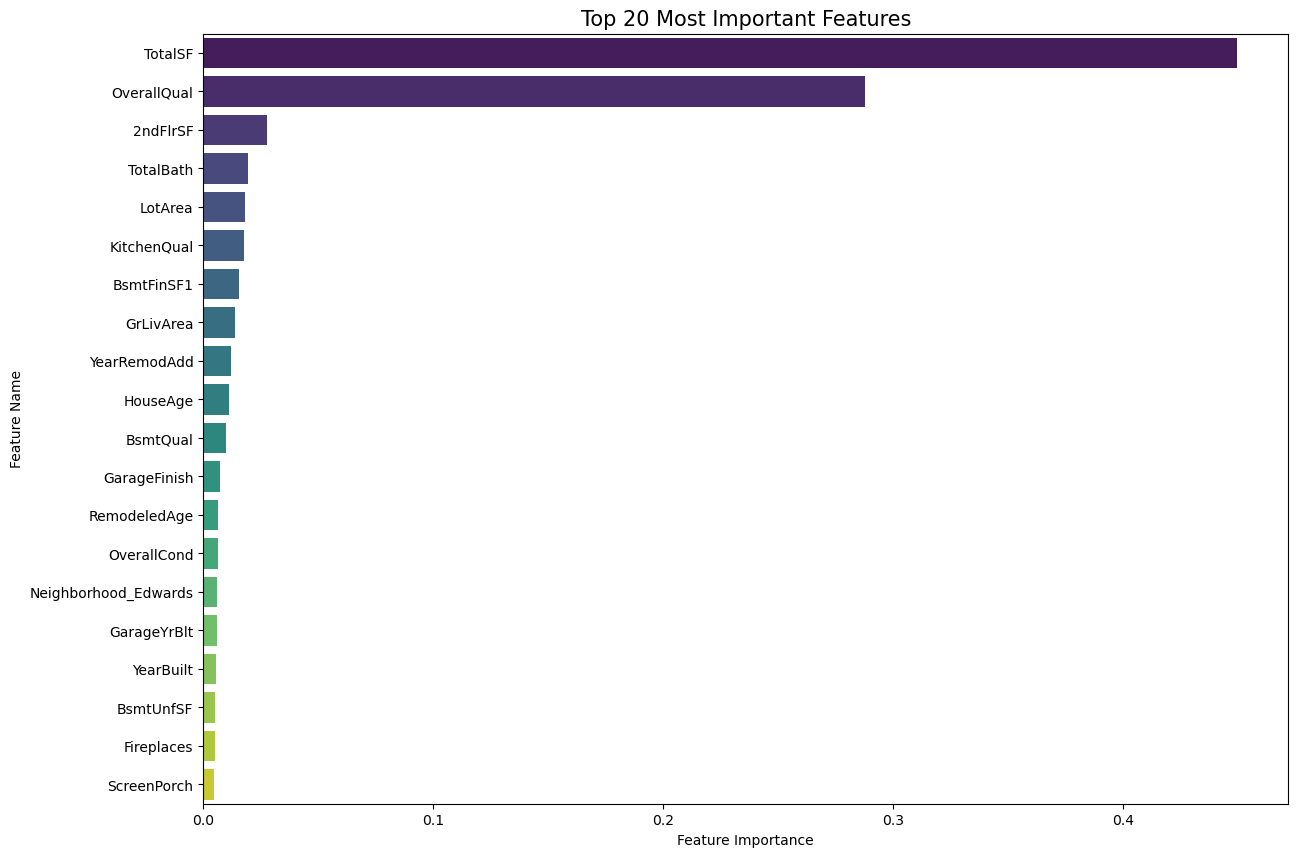

In [17]:
# Extracting feature importances
feature_importances = best_gbr.feature_importances_

# Creating a DataFrame to display features and their importances
features_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": feature_importances
})

# Sorting the DataFrame by importance
features_df = features_df.sort_values(by="Importance", ascending=False)

# Displaying the top 20 most important features
top_features = features_df.head(20)

# Plotting the top 20 most important features
plt.figure(figsize=(14, 10))
sns.barplot(data=top_features, x="Importance", y="Feature", palette="viridis")
plt.title("Top 20 Most Important Features", fontsize=15)
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.show()

# Predict the house price

In [18]:
test_predictions = best_gbr.predict(test_df.drop("SalePrice", axis=1))


In [19]:
submission_df = pd.DataFrame({
    "Id": test_df["Id"],
    "SalePrice": test_predictions
})

In [20]:
submission_df

,Id,SalePrice
0,1461,124830.347186
1,1462,155627.560155
2,1463,188707.982562
3,1464,190580.051073
4,1465,173114.664563
...,...,...
1454,2915,85349.276117
1455,2916,84941.653713
1456,2917,171768.214540
1457,2918,118039.660074


In [21]:
#submission_df.to_csv("HousePricePredic.csv", index=False)